# Binary phase evaluation

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent:

\begin{equation}
\label{eq:r_dot_DF_time}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}} \cdot r^{-5/2}\text{.}
\end{equation}

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad 
from scipy.special import hyp2f1

In [2]:
# Define some constants: 

G = 6.67 * 10**(-11) # kg m^3 / s^2
c = 3 * 10**8 # m / s
pc = 3.09 * 10**16 # m
m_sun = 2 * 10**30 # kg

In [3]:
# Fix parameters:

m1 = 1.4 * 10**3 * m_sun #1.4e3 * m_sun
m2 = 1.4 * m_sun #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

# Spike: 

rho6 =  226 * m_sun / (pc)**3
gammas = 7/3
r6 = ((3 - gammas) * 0.2**(3 - gammas) * m1 / (2 * np.pi * rho6))**(1/3)
epsv = 1 #0.58
logL = 1 / q**(1/2)

r_isco = 6 * m1 * G / c**2 # of central bh

Set a grid of radial distances to plot quantities:

In [4]:
# Set a grid of radial distances

r_grid = np.linspace(r_isco, 150 * r_isco, 10000)

### Note!

If we already integrate on the grid that starts from $\textit{isco}$ we are subtracting the $\Phi(f_{\mathrm{isco}}) = \int_{f_{\mathrm{isco}}}^{f_{\mathrm{isco}}} \frac{dt}{df} f' df' = 0$ to the phase $\Phi(f)$.

### Various functions: 

Down below I report the implementation of the functions we need. 

In [5]:
def rho_dm(r):
    
    '''Finds the density profile of the dark matter using the above formulation.'''
    
    return rho6 * (r6 / r)**(gammas)

In [6]:
def frequency_gw(r):
        
    '''Finds the binary frequency assuming circular orbits, at fixed radius r.'''
        
    return 1 / (np.pi) * np.sqrt(G * M_tot / r**3)

In [7]:
def df_dr(r): 
    
    '''Finds the binary frequency radial derivative assuming circular orbits.'''
        
    return 1 / np.pi * (- 3 / 2) * np.sqrt(G * M_tot / r**5)

In [8]:
def df_dt(r, dot_r): # I left the expression of dot_r since I already evaluated it above, can be corrected to be a single function doing it all on its own 
    
    '''Finds the binary frequency time derivative.'''
    
    return df_dr(r) * dot_r

In [9]:
def yes_or_no(elem):
    
    '''Checks whether you want a contribution or not. (could be made boolean directly)'''
        
    if elem=='y': 
        
        return 1
    
    return 0

In [10]:
# The core function

def dot_r(r):
    
    '''Find the binary change in separation over time, asking the user to choose which contribution to keep.'''
        
    acc = ''
    dm = ''
    gw = ''
    
    while(dm != 'y' and dm != 'n'):
        print('Include the dark matter contribution? (y/n)')
        dm = input()
    
    while(gw != 'y' and gw != 'n'):
        print('Include the GW contribution? (y/n)')
        gw = input()
    
    r_dot_dm = - 8 * np.pi * G**(1/2) * m2 * logL * rho6 * r6**(gammas) * epsv / (r**(gammas - 5/2) * m1 * M_tot**(1/2)) #* r**(5/2)
    
    r_dot_gw = - 64 * M_tot * G**3 * m1 * m2 / (5 * c**5 * r**3)
    
    
    return yes_or_no(dm) * r_dot_dm + yes_or_no(gw) * r_dot_gw

In [11]:
def phase_f_by_hand(df_dt): 
    
    '''Finds the binary phase as a function of frequency.'''
    
    freqs = frequency_gw(r_grid)
    to_integrate = 2 * np.pi * df_dt**(-1) * freqs 
    phase_f = []
    
    for b in freqs:  # range of values for the lower limit
        
        # Select the appropriate range of f values for integration
        f_range = freqs[freqs >= b]
        
        phase_f.append(np.trapz(to_integrate[:len(f_range)], x=f_range))

    return np.array(phase_f)

In [12]:
def phase_effective_dm(phase_vacuum):
    
    freqs = frequency_gw(r_grid)
    
    gamma_e = 5/2 #?
    
    theta = 5 / (2 * gamma_e)
    
    c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) *\
    r6**(gammas) * epsv * rho6 * logL
    
    f_eq = c_f**(3 / (11 - 2 * gammas))
    
    lambda_ = (11 - 2 * (gammas + gamma_e)) / 3
    
    f_b = 0.8163 * (m1 / (1000 * m_sun))**(-1.4412) * (m2 / m_sun)**(0.4511) * (1 - 0.4971 * np.log(gammas / 1.4396))
    
    eta = (5 + 2 * gamma_e) / (2 * (8 - gammas)) * (f_eq / f_b)**((11 - 2 * gammas) / 3)
    
    f_t = f_b
    
    y = freqs / f_t
    
    gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
    
    return phase_vacuum * (1 - eta * y**(-lambda_) * (1 - gauss_hypergeom))

In [13]:
def ddot_phase_f(df_dt): 
    
    '''Finds the binary second derivative phase as a function of frequency, using the equations above.'''
    
    return 2 * np.pi * df_dt

In [14]:
def h_0(f, ddot_phase):
    
    '''Finds the strain as a function of frequency, and \ddot{\Phi}'''
    
    return 1/2 * 4 * np.pi**(2/3) * G**(5/3) * chirp_mass**(5/3) * f**(2/3) / c**4 * (2 * np.pi / ddot_phase)**(1/2) / (4 * 10**9 * pc)

### Some plots:

- Density profiles:

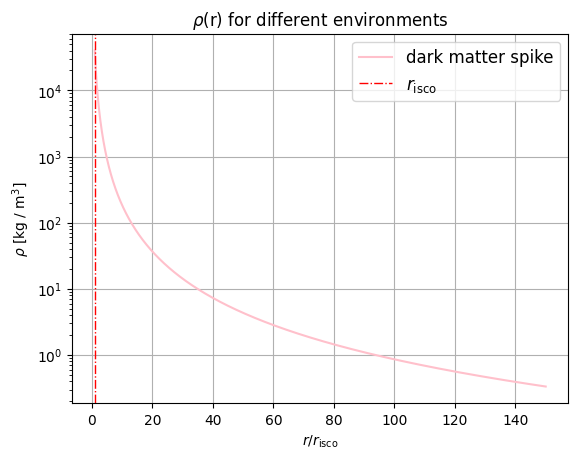

In [15]:
plt.semilogy(r_grid/r_isco, rho_dm(r_grid), c='pink', linestyle='-', label='dark matter spike')
plt.axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
plt.xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\rho$ [kg / m$^3$]', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.title(r'$\rho$(r) for different environments', fontsize=12)
plt.grid(True)  # Add gridlines
plt.legend(fontsize='large')  # Add legend
plt.show()

- Frequency:

In [16]:
# Check the frequencies are ok:

freqs = frequency_gw(r_grid)
f_isco = frequency_gw(r_isco)

print('f_isco_GW:', f_isco)
print('f_isco_grid_GW:', freqs[0])

f_isco_GW: 3.132709970902068
f_isco_grid_GW: 3.132709970902068


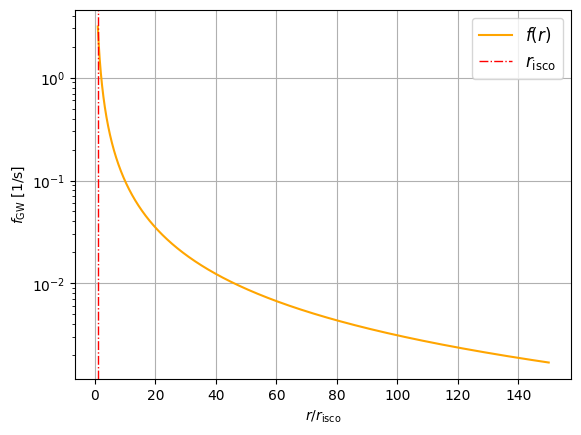

In [17]:
plt.semilogy(r_grid/r_isco, freqs, c='orange', linestyle='-', label='$f(r)$')
plt.axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1) # 1 = r_isco / r_isco
plt.xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
plt.ylabel('$f_{\mathrm{GW}}$ [1/s]', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend(fontsize='large')
plt.show()

- Frequency radial derivative:

In [18]:
df_dr_s = df_dr(r_grid)

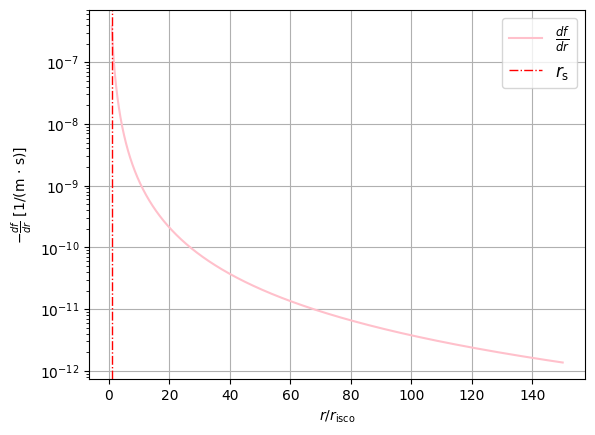

In [19]:
plt.semilogy(r_grid/r_isco, -df_dr_s, c='pink', linestyle='-', label=r'$\frac{df}{dr}$')
plt.axvline(x=1, c='red', label=r'$r_{\mathrm{s}}$', linestyle='-.', linewidth=1)
plt.xlabel(r'$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$-\frac{df}{dr}$ [1/(m $\cdot$ s)]', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)  # Add gridlines
plt.legend(fontsize='large')  # Add legend
plt.show()

- Time derivative of the radial separation: 

In [20]:
dot_r_dm = dot_r(r_grid)

Include the dark matter contribution? (y/n)
y
Include the GW contribution? (y/n)
y


In [21]:
dot_r_gw = dot_r(r_grid)

Include the dark matter contribution? (y/n)
n
Include the GW contribution? (y/n)
y


- Phase: adopt two methods and compare their outcome.

In [22]:
df_dt_dm = df_dt(r_grid, dot_r_dm)
df_dt_gw = df_dt(r_grid, dot_r_gw)

phi_dm_bh = phase_f_by_hand(df_dt_dm)
phi_gw_bh = phase_f_by_hand(df_dt_gw)

phi_dm_effective = phase_effective_dm(phi_gw_bh) 

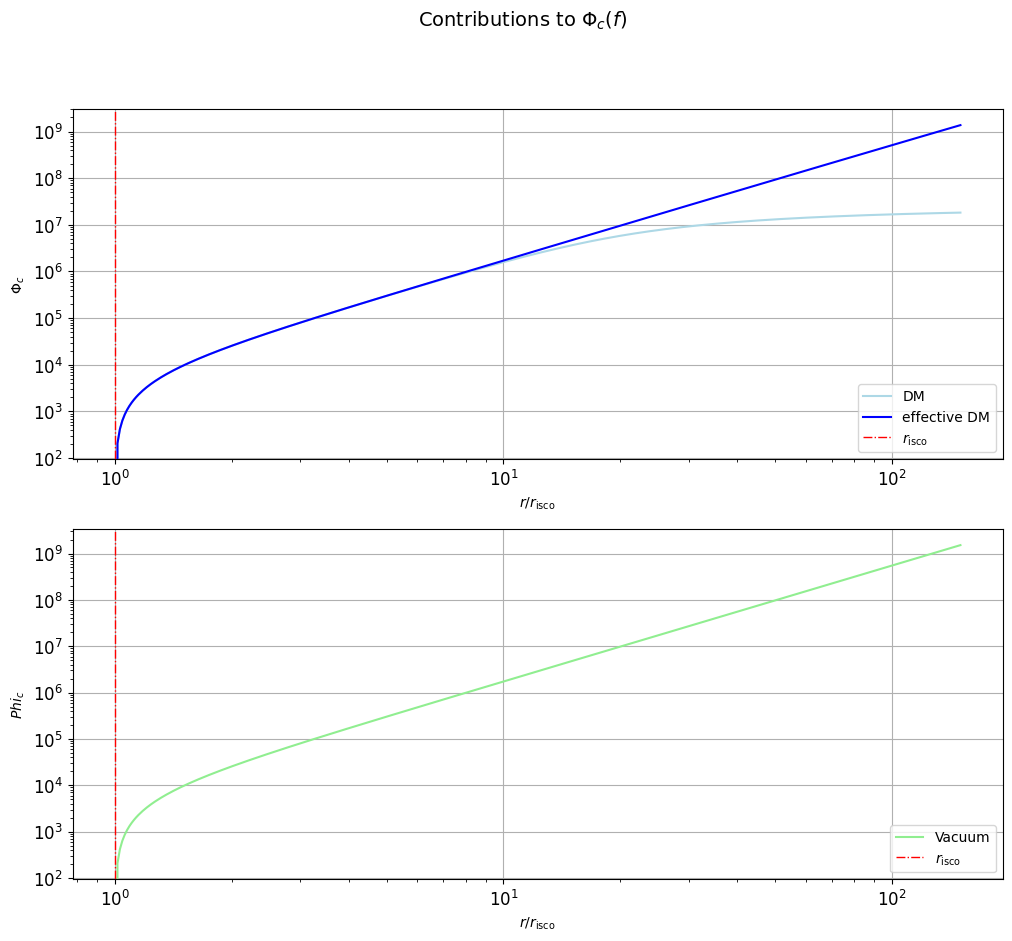

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(12,10))

plt.suptitle('Contributions to $\Phi_c(f)$', fontsize=14)


axs[0].loglog(r_grid/r_isco, -phi_dm_bh, c='lightblue', linestyle='-', label='DM')
axs[0].loglog(r_grid/r_isco, -phi_dm_effective, c='blue', linestyle='-', label='effective DM')
axs[0].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].legend()  # Add legend
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

axs[1].loglog(r_grid/r_isco, -phi_gw_bh, c='lightgreen', linestyle='-', label='Vacuum')
axs[1].axvline(x=1, c='red', label='$r_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$r/r_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$Phi_c$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True)  # Add gridlines
axs[1].legend()  # Add legend
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

plt.show()

- Difference in phase between vacuum case and environment cases $(\Phi_{\mathrm{GW}} - \Phi_{\mathrm{env}}) / 2\pi$: 

In [24]:
# Check with paper's results (https://arxiv.org/pdf/2002.12811.pdf)

a=[2.28e-2, 5.93e+5]
b=[5.92e-2, 2.01e+4]
d=[2.92e-1, 5.15e+1]
e=[0.5355666917706902, 4.777561470223041]


f = [0.006168929260775709, 1084548.5921859252]
g = [0.13362081793357317, 1354.3509382669906]
h = [1.6473398971098725, 0.7227763611033011]


In [25]:
# Define effective params 

c_f = 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(- (2 + gammas)/3) * M_tot**((1 - gammas) / 3) * r6**(gammas) * epsv * rho6 * logL
f_eq = c_f**(3 / (11- 2 * gammas))
f_b = 0.8163 * (m1 / (1000 * m_sun))**(1.4412) * (m2 / m_sun)**(0.4511) * (1 - 0.4971 * np.log(gammas / 1.4396))

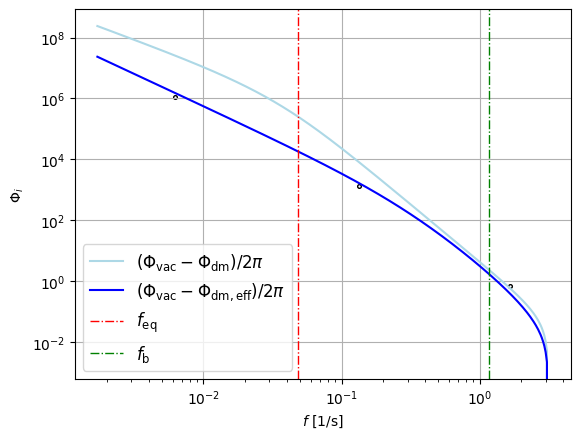

In [26]:
plt.loglog(freqs, (+phi_dm_bh - phi_gw_bh)/(2 * np.pi), c='lightblue', label='$(\Phi_{\mathrm{vac}} - \Phi_{\mathrm{dm}}) / 2\pi$')
plt.loglog(freqs, (+phi_dm_effective - phi_gw_bh)/(2 * np.pi), c='blue', label='$(\Phi_{\mathrm{vac}} - \Phi_{\mathrm{dm, eff}}) / 2\pi$')
#plt.loglog(freqs, (-phi_dm_effective + phi_gw_bh)/(2 * np.pi), c='blue')
plt.axvline(x=f_eq, c='red', label='$f_{\mathrm{eq}}$', linestyle='-.', linewidth=1)
plt.axvline(x=f_b, c='green', label='$f_{\mathrm{b}}$', linestyle='-.', linewidth=1)
plt.xlabel('$f$ [1/s]', fontsize=10)  # Increase x-label font size
plt.ylabel(r'$\Phi_i$', fontsize=10)  # Add y-label with increased font size
plt.xticks(fontsize=10)  # Increase tick font size for x-axis
plt.yticks(fontsize=10)  # Increase tick font size for y-axis
plt.grid(True)
# Scatter of data-taken points
plt.scatter(*f, marker='o', c='white', s=7, edgecolor='black')
plt.scatter(*g, marker='o', c='white', s=7, edgecolor='black')
plt.scatter(*h, marker='o',  c='white', s=7, edgecolor='black')
#plt.scatter(*e, marker='o',  c='white', s=7, edgecolor='black')
plt.tick_params(axis='y', which='minor')
#plt.xlim(10**(-2), 1)
#plt.ylim(0.3 * 10**(1), 6 * 10**7)
plt.legend(fontsize='large');